In [149]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys

In [3]:
sys.executable

'/Users/leevironty/koodi/kandi/venv/bin/python3'

In [4]:
from prophet.python import fbprophet
from prophet.python.fbprophet import models
from prophet.python.fbprophet import plot
from prophet.python.fbprophet import diagnostics

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pkg_resources
import os
from pathlib import Path
import numpy as np
import scipy
from copy import deepcopy
import tqdm



Importing plotly failed. Interactive plots will not work.


In [5]:
features = pd.read_csv('data/Features data set.csv')
features['Date'] = pd.to_datetime(features['Date'], dayfirst=True)
sales = pd.read_csv('data/sales data-set.csv')
sales['Date'] = pd.to_datetime(sales['Date'], dayfirst=True)
stores = pd.read_csv('data/stores data-set.csv')

In [6]:
sales_weekly = sales.groupby(['Store', 'Date']).sum().reset_index().merge(stores, on='Store')[['Store', 'Date', 'Weekly_Sales', 'Type', 'Size']]

In [7]:
for i in features['Store'].unique():
    store_mask = features['Store'] == i
    store_features = features[store_mask]
    cp_flags = store_features['Unemployment'].diff() != 0
    store_features.loc[cp_flags, 'u_cp'] = store_features.loc[cp_flags, 'Unemployment']
    features.loc[store_mask, 'unemployment_interpolated'] = store_features['u_cp'].interpolate().values

/Users/leevironty/koodi/kandi/venv/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/leevironty/koodi/kandi/venv/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [31]:
data = features.merge(sales_weekly, on=['Store', 'Date'])

In [32]:
def weighted_mean(chunk):
    fs = chunk[['Temperature', 'Fuel_Price', 'CPI', 'unemployment_interpolated', 'Weekly_Sales']]
    scales = chunk['Size']
    return (fs * scales.values[:, np.newaxis]).sum() / scales.sum()

In [33]:
def ar_noise(s, scale=0.05, fii=0.3):
    pass

In [242]:
def format_for_prophet(df):
    df = df.reset_index()
    df = df.rename(columns={'Date':'ds', 'Weekly_Sales':'y', 'Temperature':'temperature', 'Fuel_Price':'fuel_price', 'CPI':'cpi'})
    df['overfit'] = (df['y'] / df['y'].max()) + np.random.normal(loc=0, scale=0.003, size=df.shape[0])
    return df

In [243]:
datasets = {}
for t, chunk in data.groupby('Type'):
    wm = chunk.groupby('Date').apply(weighted_mean)
    datasets[t] = format_for_prophet(wm)

In [244]:
datasets['A']

ds  temperature  fuel_price         cpi  \
0   2010-02-05    33.690032    2.703840  170.722140   
1   2010-02-12    32.856791    2.685976  170.819624   
2   2010-02-19    36.120051    2.657191  170.866465   
3   2010-02-26    38.431706    2.678402  170.904866   
4   2010-03-05    42.054062    2.724567  170.943267   
..         ...          ...         ...         ...   
138 2012-09-28    67.947303    3.845498  179.599142   
139 2012-10-05    64.778709    3.822979  179.737298   
140 2012-10-12    56.607945    3.849897  179.875454   
141 2012-10-19    60.217018    3.834338  179.892947   
142 2012-10-26    60.535754    3.749318  179.890331   

     unemployment_interpolated             y   overfit  
0                     8.453469  1.576715e+06  0.618009  
1                     8.433678  1.516366e+06  0.593377  
2                     8.413886  1.518252e+06  0.594114  
3                     8.394094  1.370861e+06  0.538734  
4                     8.374303  1.468024e+06  0.572834  
..                         ...           ...       ...  
138                   6.835551  1.373897e+06  0.540572  
139                   6.814390  1.515141e+06  0.591364  
140                   6.810223  1.460697e+06  0.571143  
141                   6.806056  1.416175e+06  0.555929  
142                   6.801890  1.431950e+06  0.560241  

[143 rows x 7 columns]

In [245]:
fit_kwargs = {'adapt_delta': 0.9, 'max_treedepth': 11, 'adapt_kappa': 0.75}

In [246]:
def lppd(model, s=None):
    
    return np.log(np.exp(model.params['log_lik']).mean(axis=0)).sum()


def aic(model):
    k = model.params['beta'].shape[1] + model.params['delta'].shape[1] + 2
    return -2*lppd(model) + 2*k


def log_lik_bayes_theta(model):
    mu = model.predict()['yhat']/model.y_scale
    y = model.history['y']/model.y_scale
    sigma = model.params['sigma_obs'].mean()
    return scipy.stats.norm.logpdf(y, loc=mu, scale=sigma).sum()


def dic(model):  # Vois olla nopeempi, nyt log_lik_bayes laskettu kahdesti
    return -2*log_lik_bayes_theta(model) + 2*p_dic(model)


def dic_alt(model):
    return -2*log_lik_bayes_theta(model) + 2*p_dic_alt(model)


def waic(model):
    #ll = model.params['log_lik']
    #pwaic2 = 1/(model.mcmc_samples - 1)*((ll - ll.mean(axis=0))**2).sum(axis=0).sum()
    return -2*lppd(model) + 2*p_waic_2(model)

def loo_cv(model):
    k = model.history.shape[0]
    return k_fold_loo_cv(model, k)

def k_fold_loo_cv(model, k=10):  # Oletetaan, että residuaalit iid
    og_lppd = lppd(model)
    data = model.history.sample(frac=1).reset_index(drop=True)  # shuffle
    breakpoints = np.linspace(0, data.shape[0], k+1, endpoint=True).astype(int)

    #scipy.stats.norm.pdf(p, loc=df['y'].values, scale=m1.params['sigma_obs'][:, np.newaxis])  # TODO: muista skaalaus
    def train_test_split(i):  # OK
        test = data[breakpoints[i]:breakpoints[i+1]].sort_values(by='t')#.reset_index().drop(columns='index')
        train = data.drop(test.index, axis=0).sort_values(by='t').reset_index(drop=True)
        test = test.reset_index(drop=True)
        return (train, test) 

    res = 0
    lppds = []
    params = []
    for i in range(k):
    #for i in tqdm.tqdm(range(k)):
        #print(f'CV {i}')
        train, test = train_test_split(i)
        clean_model = prophet_copy(model)
        fit = clean_model.fit(train, control=fit_kwargs)  # Voiko olla ongelma, että t scale muuttuu?
        params.append(fit.params.copy())
        p = predict_with_samples(fit, test)  
        lik = scipy.stats.norm.pdf(p/fit.y_scale, loc=test['y'].values/fit.y_scale, scale=fit.params['sigma_obs'][:, np.newaxis]) # OK
        res += np.log(lik.prod(axis=1).mean())  # OK

        #p_i = predict_with_samples(fit, model.history)
        #b_lik = scipy.stats.norm.pdf(p_i/fit.y_scale, loc=model.history['y'].values/fit.y_scale, scale=fit.params['sigma_obs'][:, np.newaxis])
        #lppd_i = np.log(b_lik.prod(axis=1).mean())
        #mean_lppd_i += np.log(b_lik.prod(axis=1).mean())/k  # Taitaa olla väärin
        lppd_i = 0
        for j in range(k):
            #print(f'lppd {j}')
            train_i, test_i = train_test_split(j)
            p_i = predict_with_samples(fit, test_i)
            lik_i = scipy.stats.norm.pdf(p_i/fit.y_scale, loc=test_i['y'].values/fit.y_scale, scale=fit.params['sigma_obs'][:, np.newaxis])
            lppd_i += np.log(lik_i.prod(axis=1).mean())
        lppds.append(lppd_i)

    mean_lppd_i = sum(lppds) / k

    bias = og_lppd - mean_lppd_i
    lppd_bias_corrected = res + bias
    eff_params = mean_lppd_i - res
    return {'lppd_loo_cv': res, 'lppd_cloo_cv': lppd_bias_corrected, 'bias': bias, 'p_cloo': eff_params, 'fitted_params':params}
    

def prophet_copy(m):
    if m.history is None:
        raise Exception('Mallin täytyy olla eka fitattu originaalilla datalla. CV tulee laskea siis vikana')

    if m.specified_changepoints:
        changepoints = m.changepoints
        #if cutoff is not None:
        #    # Filter change points '<= cutoff'
        #    changepoints = changepoints[changepoints <= cutoff]
    else:
        changepoints = None

    # Auto seasonalities are set to False because they are already set in
    # m.seasonalities.
    m2 = m.__class__(
        growth=m.growth,
        n_changepoints=m.n_changepoints,
        changepoint_range=m.changepoint_range,
        changepoints=changepoints,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays=m.holidays,
        seasonality_mode=m.seasonality_mode,
        seasonality_prior_scale=m.seasonality_prior_scale,
        changepoint_prior_scale=m.changepoint_prior_scale,
        holidays_prior_scale=m.holidays_prior_scale,
        mcmc_samples=m.mcmc_samples,
        interval_width=m.interval_width,
        uncertainty_samples=m.uncertainty_samples,
        stan_backend=m.stan_backend.get_type()
    )
    #m2.changepoints_t = deepcopy(m.changepoints_t)
    m2.extra_regressors = deepcopy(m.extra_regressors)
    m2.seasonalities = deepcopy(m.seasonalities)
    m2.country_holidays = deepcopy(m.country_holidays)
    return m2    
    
    
def predict_with_samples(model, df):
    """
    In: model, prediction df
    Out: s*n matrix of predictions
    """
    # Fix scaling issues between different datasets
    if 'floor' not in df:
        df['floor'] = 0
    df['t'] = (df['ds'] - model.start) / model.t_scale
    df['y_scaled'] = (df['y'] - df['floor']) / model.y_scale
    
    trend = predict_trend_with_samples(model, df)
    sf = predict_seasonal_components_with_samples(model, df)
    return trend * (1 + sf['multiplicative_terms']) + sf['additive_terms']
    


def predict_seasonal_components_with_samples(model, df): # TODO: make_all antaa train setin kokoisen framen ulos
    # Väärin, tutki miks ei toimi
    
    seasonal_features, _, component_cols, _ = (
        model.make_all_seasonality_features(df)
    )
    X = seasonal_features.values
    data = {}
    for component in component_cols.columns:
        beta_c = model.params['beta'] * component_cols[component].values
        comp = (X @ beta_c.T).T
        if component in model.component_modes['additive']:
            comp *= model.y_scale
        data[component] = comp
    return data
    
def predict_trend_with_samples(model, df):  # TODO: implement also for logistic and flat trends
    
    
    #k = np.nanmean(self.params['k'])
    #m = np.nanmean(self.params['m'])
    #deltas = np.nanmean(self.params['delta'], axis=0)

    #t = np.array(df['t'])
    #if self.growth == 'linear':
    #    trend = self.piecewise_linear(t, deltas, k, m, self.changepoints_t)
    #elif self.growth == 'logistic':
    #    cap = df['cap_scaled']
    #    trend = self.piecewise_logistic(
    #        t, cap, deltas, k, m, self.changepoints_t)
    #elif self.growth == 'flat':
    #    # constant trend
    #    trend = self.flat_trend(t, m)
        
    t_cp = model.changepoints_t
    n_cp = t_cp.size
    n = df.shape[0]
    A = np.zeros([n, n_cp])
    for i in range(n):
        A[i, :] = t_cp <= df.iloc[i, :]['t']  # TODO: katso että kumpikin on timestamp tai float
    
    delta = model.params['delta']
    k = model.params['k']
    m = model.params['m']
    
    trend = df['t'].values * (k + A @ delta.T).T + (m + A @ (-t_cp * delta).T).T
    trend *= model.y_scale

    return trend
    
    
    

In [247]:
def p_dic(model):
    return 2*(log_lik_bayes_theta(model) - model.params['log_lik'].sum(axis=1).mean())
              
def p_waic_2(model):
    ll = model.params['log_lik']
    return ((ll - ll.mean(axis=0))**2).var(axis=0, ddof=1).sum()
    #return 1/(model.mcmc_samples - 1)*((ll - ll.mean(axis=0))**2).sum(axis=0).sum()  # Tuplacheckattava

def p_dic_alt(model):  # Pitäis olla oikein
    return model.params['log_lik'].sum(axis=1).var()*2
              

In [425]:
def compare_models(ms, data, no_fit=False, metrics=None, verbose=True):
    """Lista malleista ja oikean mallinen df (sis. y, ds, x) -> metriikat malleille.
    Mallit ei saa olla fitattuja."""
    res = {}
    if metrics is None:
        metrics = {'AIC': aic, 'DIC': dic, 'DIC_alt': dic_alt, 'WAIC2': waic, 'p_dic': p_dic, 'p_dic_alt': p_dic_alt, 'p_waic2': p_waic_2, '10-fold_cv': lambda x: k_fold_loo_cv(x, k=10)}
    
    if no_fit:
        fits = ms
    else:
        fits = [m.fit(data, control=fit_kwargs) for m in ms]
    for metric_name, metric in metrics.items():
        res[metric_name] = {}
        if verbose:
            print(f'Evaluating {metric_name}')
        for f in fits:
            value = metric(f)
            res[metric_name][f] = value
            if verbose:
                if 'cv' not in metric_name:
                    print(value)
                else:
                    print('Done')
        if verbose:
            print('')
    return res

    

In [474]:
m2.params['delta'][:100].shape

(100, 25)

In [586]:
def sweep_samples(model, data, warmup=None, metrics = {'aic':aic, 'dic':dic, 'waic':waic}, points = 30):
#warmup=500
#data = datasets['A']
#model = fbprophet.Prophet(mcmc_samples=1000, seasonality_mode='additive')
#metrics = {'aic':aic, 'dic':dic, 'waic':waic}

    if warmup is None:
        warmup = model.mcmc_samples//2
    max_samples = model.mcmc_samples - warmup
    fit = model.fit(data, control=fit_kwargs, warmup=warmup)
    og_params = model.params.copy()

    res = pd.DataFrame(columns=metrics.keys())

    def sliced_params(s):
        stan_fit = fit.stan_backend.stan_fit
        ex = stan_fit.extract(permuted=False)[:, :, :-1]
        fn_split = pd.Series(stan_fit.flatnames).apply(lambda x: x.split('[')[0])
        var_names = fn_split.unique()
        params = {}
        for name in var_names:
            reshape_mask = fn_split == name
            reshape_dim = reshape_mask.sum()
            params[name] = ex[:s, :, (fn_split == name).values].reshape((s*4, reshape_dim), order='F')
            np.random.shuffle(params[name])
        return params

    
    for s in np.linspace(max_samples//points, max_samples, points).astype(int):
        row = pd.Series()
        row['samples'] = s
        fit.params = sliced_params(s)
        for metric_name, metric in metrics.items():
            row[metric_name] = metric(fit)
        res = res.append(row, ignore_index=True)
    return res
    

In [571]:
warmup=500
data = datasets['A']
model = fbprophet.Prophet(mcmc_samples=1000, seasonality_mode='additive')
metrics = {'aic':aic, 'dic':dic, 'waic':waic}

if warmup is None:
    warmup = model.mcmc_samples//2
max_samples = model.mcmc_samples - warmup
fit = model.fit(data, control=fit_kwargs, warmup=warmup)
og_params = model.params.copy()

res = pd.DataFrame(columns=metrics.keys())

def sliced_params(s):
    stan_fit = fit.stan_backend.stan_fit
    ex = stan_fit.extract(permuted=False)[:, :, :-1]
    fn_split = pd.Series(stan_fit.flatnames).apply(lambda x: x.split('[')[0])
    var_names = fn_split.unique()
    params = {}
    for name in var_names:
        reshape_mask = fn_split == name
        reshape_dim = reshape_mask.sum()
        params[name] = ex[:s, :, (fn_split == name).values].reshape((s*4, reshape_dim), order='F')
        np.random.shuffle(params[name])
    return params

points = 30
for s in np.linspace(max_samples//points, max_samples, points).astype(int):
    row = pd.Series()
    row['samples'] = s
    fit.params = sliced_params(s)
    for metric_name, metric in metrics.items():
        row[metric_name] = metric(fit)
    res = res.append(row, ignore_index=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/leevironty/koodi/kandi/venv/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


<AxesSubplot:xlabel='samples'>

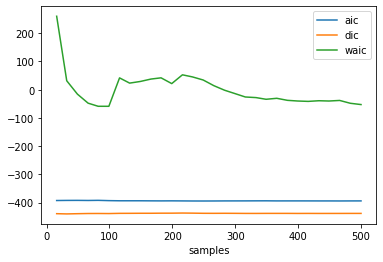

In [565]:
stan_fit = fit.stan_backend.stan_fit
ex = stan_fit.extract(permuted=False)[:, :, :-1]
fn_split = pd.Series(stan_fit.flatnames).apply(lambda x: x.split('[')[0])
var_names = fn_split.unique()
params = {}
for name in var_names:
    reshape_mask = fn_split == name
    reshape_dim = reshape_mask.sum()
    params[name] = ex[:s, :, (fn_split == name).values].reshape((s*4, reshape_dim), order='F')
    np.random.shuffle(params[name])

In [558]:
ex[:300, :, (fn_split == 'beta').values].reshape((1200, 20), order='F').mean(axis=0)

array([-8.10688804e-03,  2.34439280e-02, -2.59126893e-02,  2.88507398e-02,
       -3.19480518e-02,  7.89177336e-03, -3.47262608e-02, -3.55588256e-03,
       -2.09700670e-02, -3.40825129e-03, -2.98261362e-02, -1.67002179e-03,
       -2.04118223e-02,  1.56259973e-05, -1.09143991e-02,  7.54022339e-03,
       -1.38020530e-02,  4.25109499e-03, -1.29642765e-02,  2.68225929e-03])

In [559]:
stan_fit.extract()['beta'].mean(axis=0)

array([-8.24430740e-03,  2.33331922e-02, -2.58395985e-02,  2.87780262e-02,
       -3.20740155e-02,  7.77347926e-03, -3.47049165e-02, -3.55591437e-03,
       -2.10903771e-02, -3.37353445e-03, -2.98100395e-02, -1.70718372e-03,
       -2.05274299e-02,  2.44166641e-05, -1.10369053e-02,  7.48977641e-03,
       -1.38531885e-02,  4.19404051e-03, -1.28557620e-02,  2.67058638e-03])

In [587]:
model = fbprophet.Prophet(mcmc_samples=10000, seasonality_mode='additive')
res = sweep_samples(model, datasets['A'], warmup=500, metrics={'aic':aic, 'waic':waic}, points=200)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/leevironty/koodi/kandi/venv/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [590]:
res['warmup'] = 500

In [591]:
res.to_csv('m2-samples-sweep.csv')

<AxesSubplot:xlabel='samples'>

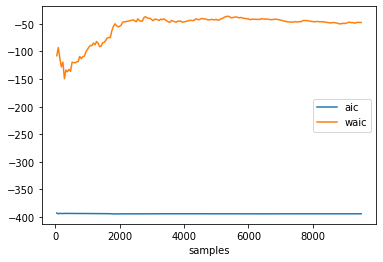

In [588]:
res.plot(x='samples')

In [465]:
list(res['aic'].keys())[0].params.copy()

{'k': array([-0.08932619, -0.18473594, -0.01847743, ...,  0.09336542,
        -0.3620773 , -0.45284069]),
 'm': array([0.61823302, 0.74958561, 0.51854628, ..., 0.59731425, 0.64884886,
        0.77016499]),
 'delta': array([[ 0.03009094, -0.01355913, -0.18884629, ...,  0.01990708,
         -0.09238626,  0.00205045],
        [-0.00221445, -0.10303757, -0.00853216, ...,  0.0608656 ,
         -0.01965431, -0.16582457],
        [ 0.00541807, -0.01492349,  0.04617806, ...,  0.02858826,
          0.01259001,  0.01431709],
        ...,
        [-0.21870208, -0.01656428, -0.02978755, ...,  0.02560815,
         -0.00150175, -0.01880723],
        [ 0.06992777,  0.01972463,  0.06031807, ..., -0.01031779,
         -0.01113447, -0.02077215],
        [ 0.13614278,  0.01597364, -0.02099353, ..., -0.0320556 ,
          0.03241661,  0.03906001]]),
 'sigma_obs': array([0.05565306, 0.04524142, 0.04807058, ..., 0.04340642, 0.05135029,
        0.05229213]),
 'beta': array([[ 0.00745245,  0.07429918, -0.0270

In [480]:
samples = 1000
# Initialize models
m1 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive')
m2 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive')
m3 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive', seasonality_prior_scale=1)
m4 = fbprophet.Prophet(mcmc_samples=samples, yearly_seasonality=20, seasonality_mode='additive', seasonality_prior_scale=1)
m5 = fbprophet.Prophet(mcmc_samples=samples, yearly_seasonality=False, n_changepoints=1, seasonality_prior_scale=0.1, changepoint_prior_scale=0.05)

for r in ['temperature', 'fuel_price', 'cpi', 'unemployment_interpolated']:
    m2.add_regressor(r)
    
m3.add_regressor('overfit', standardize=False, prior_scale=10)
m5.add_regressor('overfit', standardize=False, prior_scale=10) # Ei vaikutusta

In [416]:
{metric:list(v.values())[0] for metric, v in res.items()}

{'aic': -384.8779188537933,
 'dic': -432.1390722343087,
 'waic': -7.837502984999105}

In [420]:
stability['samples'] = range(1000, 10001, 100)

<AxesSubplot:xlabel='samples'>

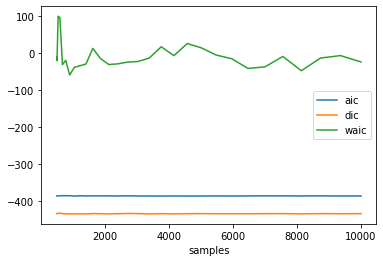

In [458]:
stability.plot(kind='line', x='samples')

In [459]:
res

{'aic': {<prophet.python.fbprophet.forecaster.Prophet at 0x7fb3df5e8950>: -385.53959611959965},
 'dic': {<prophet.python.fbprophet.forecaster.Prophet at 0x7fb3df5e8950>: -433.5859083617772},
 'waic': {<prophet.python.fbprophet.forecaster.Prophet at 0x7fb3df5e8950>: -23.31472015489146}}

In [456]:
stability.head()

aic         dic        waic  samples
0 -385.815630 -433.361217   -9.548437    500.0
1 -385.679401 -434.089652  -19.753170    511.0
2 -385.305483 -432.685408  100.425834    545.0
3 -385.409874 -431.977419   96.657851    601.0
4 -384.829367 -433.648488  -30.620649    680.0

In [454]:
stability.to_csv('m2-samples-500-to-10k.csv')

In [460]:
(np.linspace(0, 1, 30)**2 * 9500 + 500).sum()

111637.93103448274

In [445]:
stability = pd.DataFrame(columns=['aic', 'dic', 'waic'])
for i_samples in tqdm.tqdm((np.linspace(0, 1, 30)**2 * 9500 + 500).astype(int)):
    m = fbprophet.Prophet(mcmc_samples=i_samples, seasonality_mode='additive')
    for r in ['temperature', 'fuel_price', 'cpi', 'unemployment_interpolated']:
        m.add_regressor(r)
    
    res = compare_models([m], datasets['A'], metrics={'aic': aic, 'dic': dic, 'waic': waic}, verbose=False)
    row = pd.Series({metric:list(v.values())[0] for metric, v in res.items()})
    row['samples'] = i_samples
    stability = stability.append(row, ignore_index=True)
    

  0%|          | 0/30 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  3%|▎         | 1/30 [00:15<07:15, 15.01s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  7%|▋         | 2/30 [00:33<07:27, 15.97s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 10%|█         | 3/30 [00:52<07:40, 17.06s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [249]:
m5_test = fbprophet.Prophet(mcmc_samples=samples, yearly_seasonality=False, n_changepoints=1, seasonality_prior_scale=0.1, changepoint_prior_scale=0.05)
m5_test.add_regressor('overfit', standardize=False, prior_scale=10)

In [363]:
m2.params['beta'][:, 0]

array([0.0094434 , 0.01300863, 0.00583609, ..., 0.00599727, 0.00823658,
       0.02280184])

In [444]:
(np.linspace(0, 1, 30)**2 * 49500 + 500).astype(int)

array([  500,   558,   735,  1029,  1441,  1971,  2618,  3384,  4266,
        5267,  6385,  7621,  8975, 10447, 12036, 13743, 15567, 17510,
       19570, 21747, 24043, 26456, 28987, 31636, 34402, 37286, 40288,
       43407, 46645, 50000])

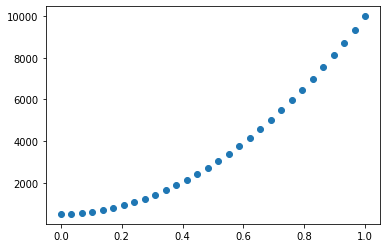

In [446]:
plt.scatter(np.linspace(0, 1, 30), np.linspace(0, 1, 30)**2 * 9500 + 500)

In [382]:
m2.params['beta'].mean(axis=0)

array([ 0.00311449,  0.07035581, -0.02739475,  0.03376293, -0.02990396,
        0.00796467, -0.03382856, -0.00450087, -0.0223654 , -0.00443616,
       -0.03040229, -0.00131301, -0.02119863,  0.00012021, -0.01184013,
        0.00788113, -0.01342074,  0.00385515, -0.01248116,  0.00175249,
        0.03371823,  0.00777928,  0.003374  , -0.01826373])

In [390]:
inference = arviz.convert_to_inference_data(m2.stan_backend.stan_fit)

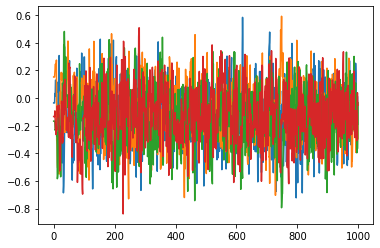

In [405]:
plt.plot(m2.stan_backend.stan_fit.extract(pars='k', inc_warmup=True, permuted=False)['k'])

In [161]:
used_models = [m4]

In [142]:
used_models = [m1, m3, m5]

In [169]:
used_models = [m1, m2, m3, m4, m5]

In [250]:
compare_models([m5_test], datasets['A'], metrics = {'aic':aic, 'dic':dic, 'waic':waic})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Evaluating aic
-1222.9611676558588

Evaluating dic
-1222.4422827868175

Evaluating waic
-1229.3662265728333



{'aic': {<prophet.python.fbprophet.forecaster.Prophet at 0x7fb3fb445510>: -1222.9611676558588},
 'dic': {<prophet.python.fbprophet.forecaster.Prophet at 0x7fb3fb445510>: -1222.4422827868175},
 'waic': {<prophet.python.fbprophet.forecaster.Prophet at 0x7fb3fb445510>: -1229.3662265728333}}

In [170]:
%time
res_A = compare_models(used_models, datasets['A'], metrics = {'aic':aic, 'dic':dic, 'waic':waic, '10-fold-cv': lambda x: k_fold_loo_cv(x, 10)})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Evaluating aic
-393.2732326685779
-386.10884282088375
-594.8464558420906
-456.0198542204125
-650.7736327232907

Evaluating dic
-438.2955509558217
-433.48377853992145
-641.9225956152752
-511.90706714694625
-649.4873362202436

Evaluating waic
-47.28875196498677
-5.772068663901507
-575.8605334072607
-31.473995908357665
-649.5123047560776

Evaluating 10-fold-cv
Done
Done
Done
Done
Done



In [163]:
m4.params['beta'].shape

(2000, 40)

In [212]:
m3.params['beta'].mean(axis=0)

array([-5.70115741e-03,  3.93868346e-03, -7.78367191e-03,  9.87720949e-03,
       -4.34508539e-03, -8.43340141e-04, -6.65096319e-03,  2.16347592e-03,
       -5.28611155e-03, -2.11459533e-03, -4.15437630e-03,  3.38572074e-03,
       -5.77092079e-03, -1.94572325e-03, -4.89881790e-03,  1.47876651e-04,
        1.94862723e-03,  1.12075480e-03, -3.55256123e-03, -2.81524512e-03,
        8.02686804e-01])

In [211]:
m5_test.params['beta'].mean(axis=0)

array([0.99969518])

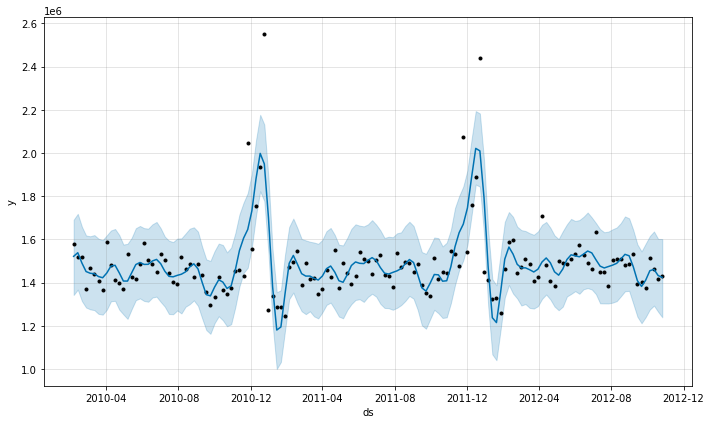

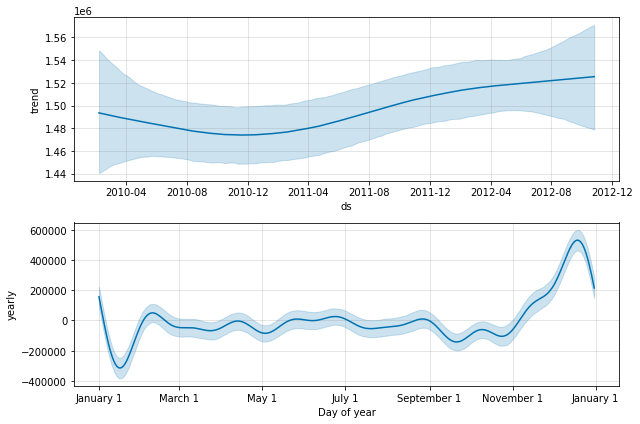

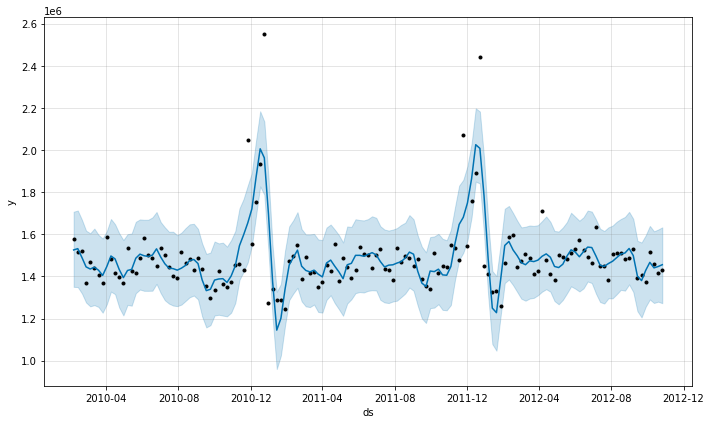

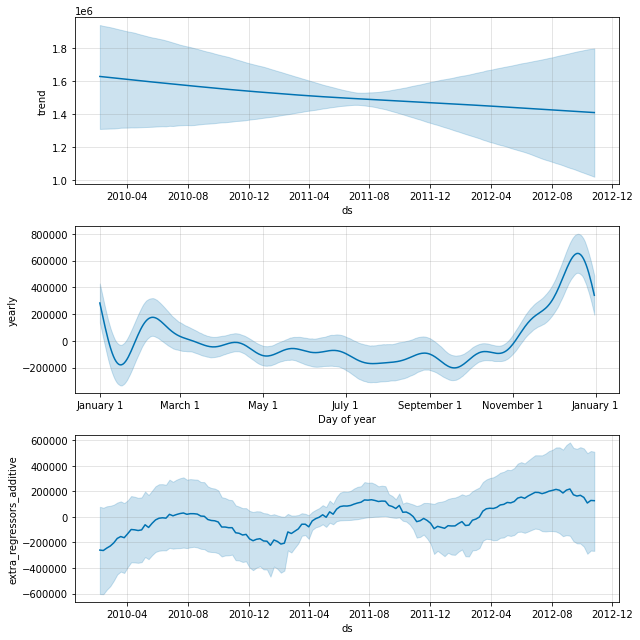

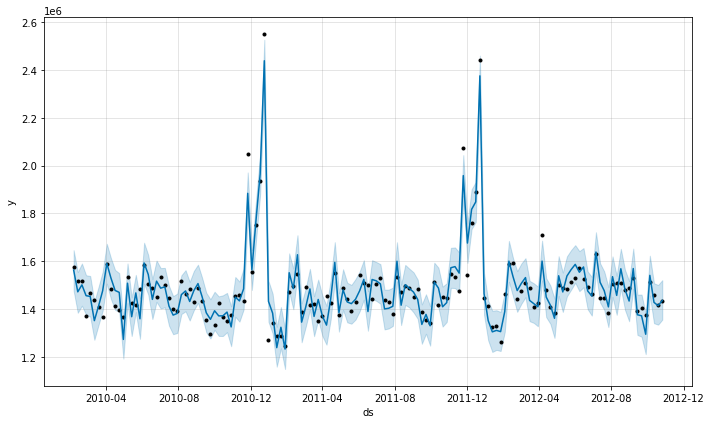

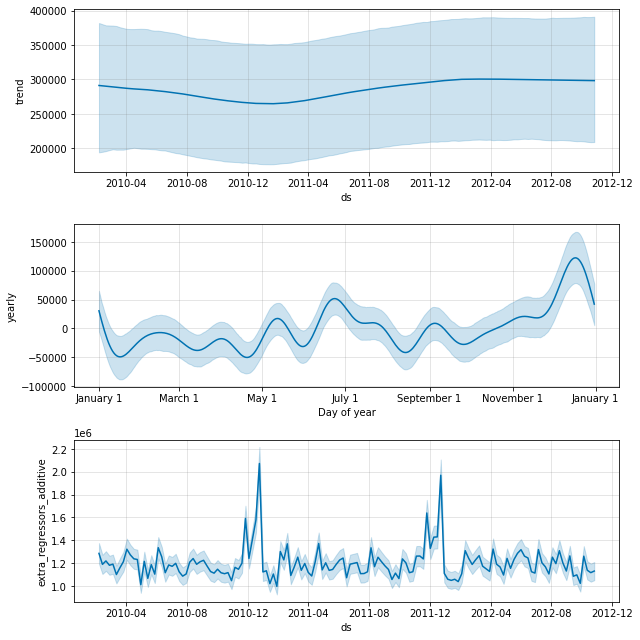

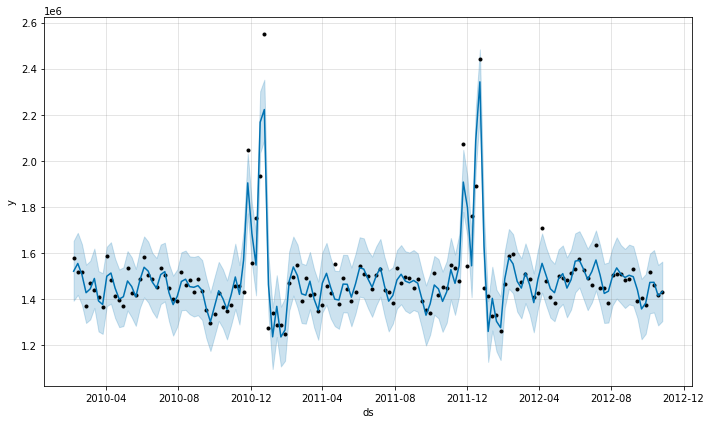

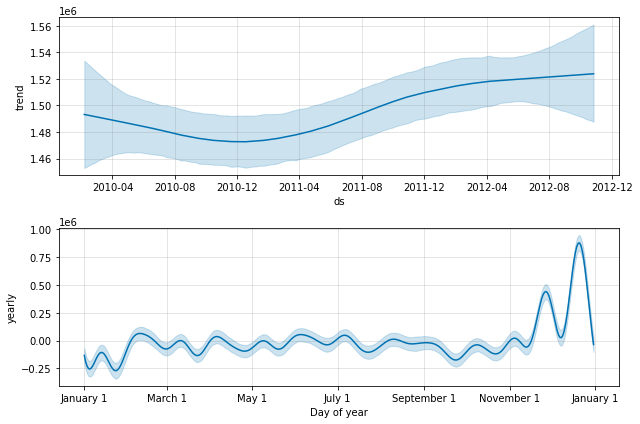

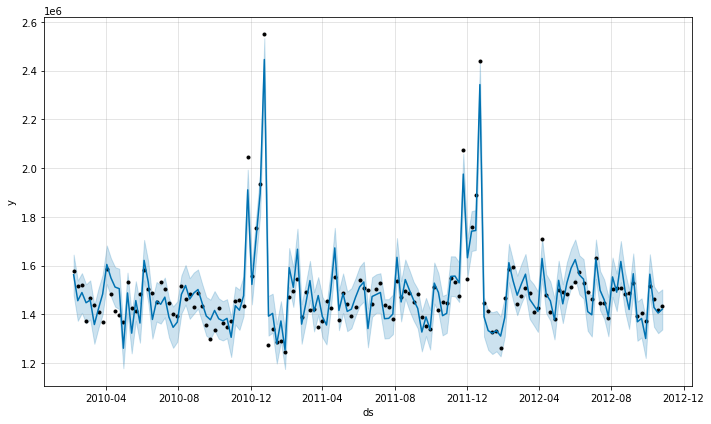

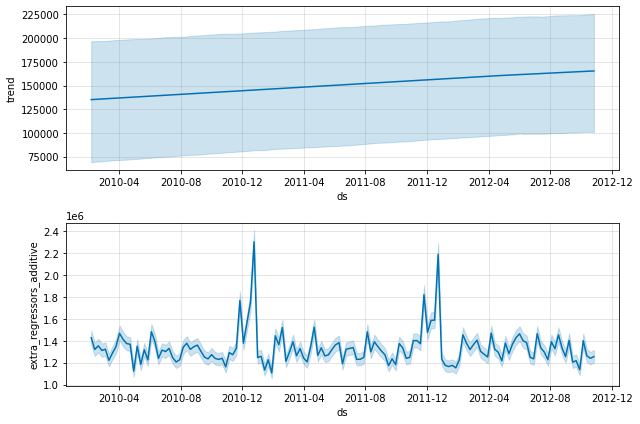

In [171]:
for m in used_models:
    fc = m.predict()
    m.plot(fc);
    m.plot_components(fc);

In [263]:
(m5_test.history['overfit'] - m5_test.history['y_scaled']).std()

0.003313117382662785

In [264]:
(m5.history['overfit'] - m5.history['y_scaled']).std()

0.025650304467798674

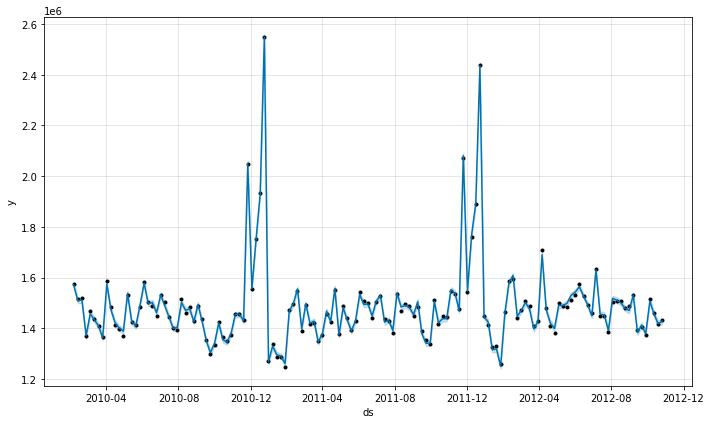

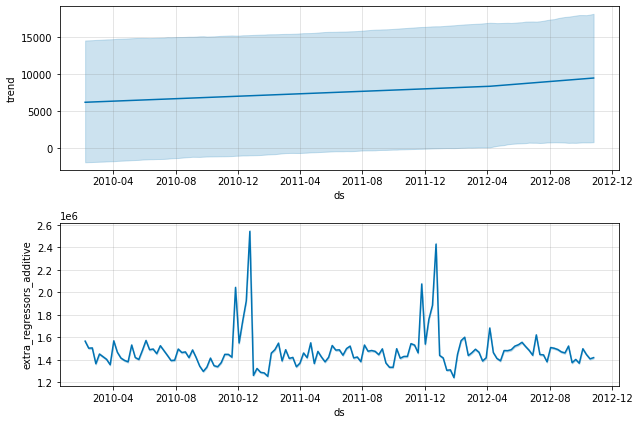

In [262]:
m5_test.plot(m5_test.predict());
m5_test.plot_components(m5_test.predict());

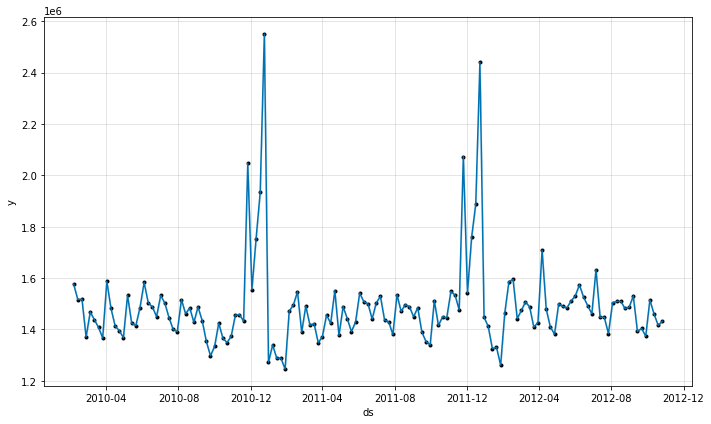

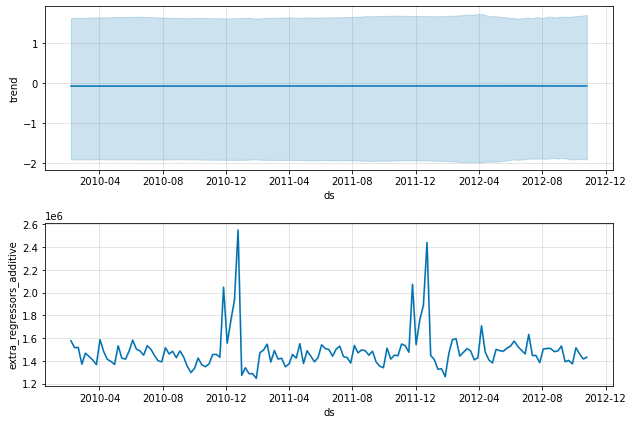

In [233]:
m5_test.plot(m5_test.predict());
m5_test.plot_components(m5_test.predict());

<AxesSubplot:xlabel='ds'>

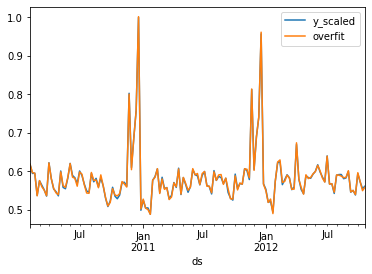

In [221]:

ax = m5_test.history.plot(x='ds', y='y_scaled')
m5_test.history.plot(x='ds', y='overfit', ax=ax)

In [173]:
m5.history['y_scaled'].mean()

0.5828448647174851

In [174]:
m5.history['overfit'].mean()

0.5876918005062771

In [194]:
(m5.history['overfit'] - m5.history['y_scaled']).mean()

0.0048469357887920925

In [204]:
(m5.params['m'][:, np.newaxis] / m5.history['y_scaled'].values[np.newaxis, :]).mean()

0.09185084611800698

In [181]:
res = compare_models([m1, m2], format_for_prophet(data[data['Store']==2]), no_fit=True, metrics = {'10-fold-cv':lambda x: k_fold_loo_cv(x, k=10)})

Evaluating 10-fold-cv
Done
Done



In [253]:
result_df = pd.DataFrame(index=used_models)

In [254]:
for metric_name, values in res_A.items():
    for model, value in values.items():
        if type(value) == dict:
            cols = [c for c in value.keys() if c != 'fitted_params']
            for c in cols:
                result_df.loc[model, f'{metric_name}_{c}'] = value[c]
        else:
            result_df.loc[model, metric_name] = value
result_df = result_df.rename(index={m1:'m1', m2:'m2', m3:'m3', m4:'m4', m5:'m5'})

In [255]:
result_df

aic         dic        waic  10-fold-cv_lppd_loo_cv  \
m1 -393.273233 -438.295551  -47.288752              211.248997   
m2 -386.108843 -433.483779   -5.772069              206.478646   
m3 -594.846456 -641.922596 -575.860533              306.996194   
m4 -456.019854 -511.907067  -31.473996              141.942643   
m5 -650.773633 -649.487336 -649.512305              323.798699   

    10-fold-cv_lppd_cloo_cv  10-fold-cv_bias  10-fold-cv_p_cloo  
m1               213.860186         2.611189          29.776430  
m2               208.540084         2.061438          35.514337  
m3               311.499716         4.503522          33.923512  
m4               151.167944         9.225301         143.841983  
m5               324.968025         1.169326           4.418791

In [256]:
result_df.round(decimals=2).to_csv('dataset_A.csv')

In [257]:
import pickle

In [261]:
with open('dataset_A_fitted_models.pkl', 'wb') as f:
    pickle.dump(used_models, f)


/Users/leevironty/koodi/kandi/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


In [259]:
pickle.dump(used_models, 'dataset_A_fitted_models.pkl')

TypeError: file must have a 'write' attribute

In [265]:
import arviz

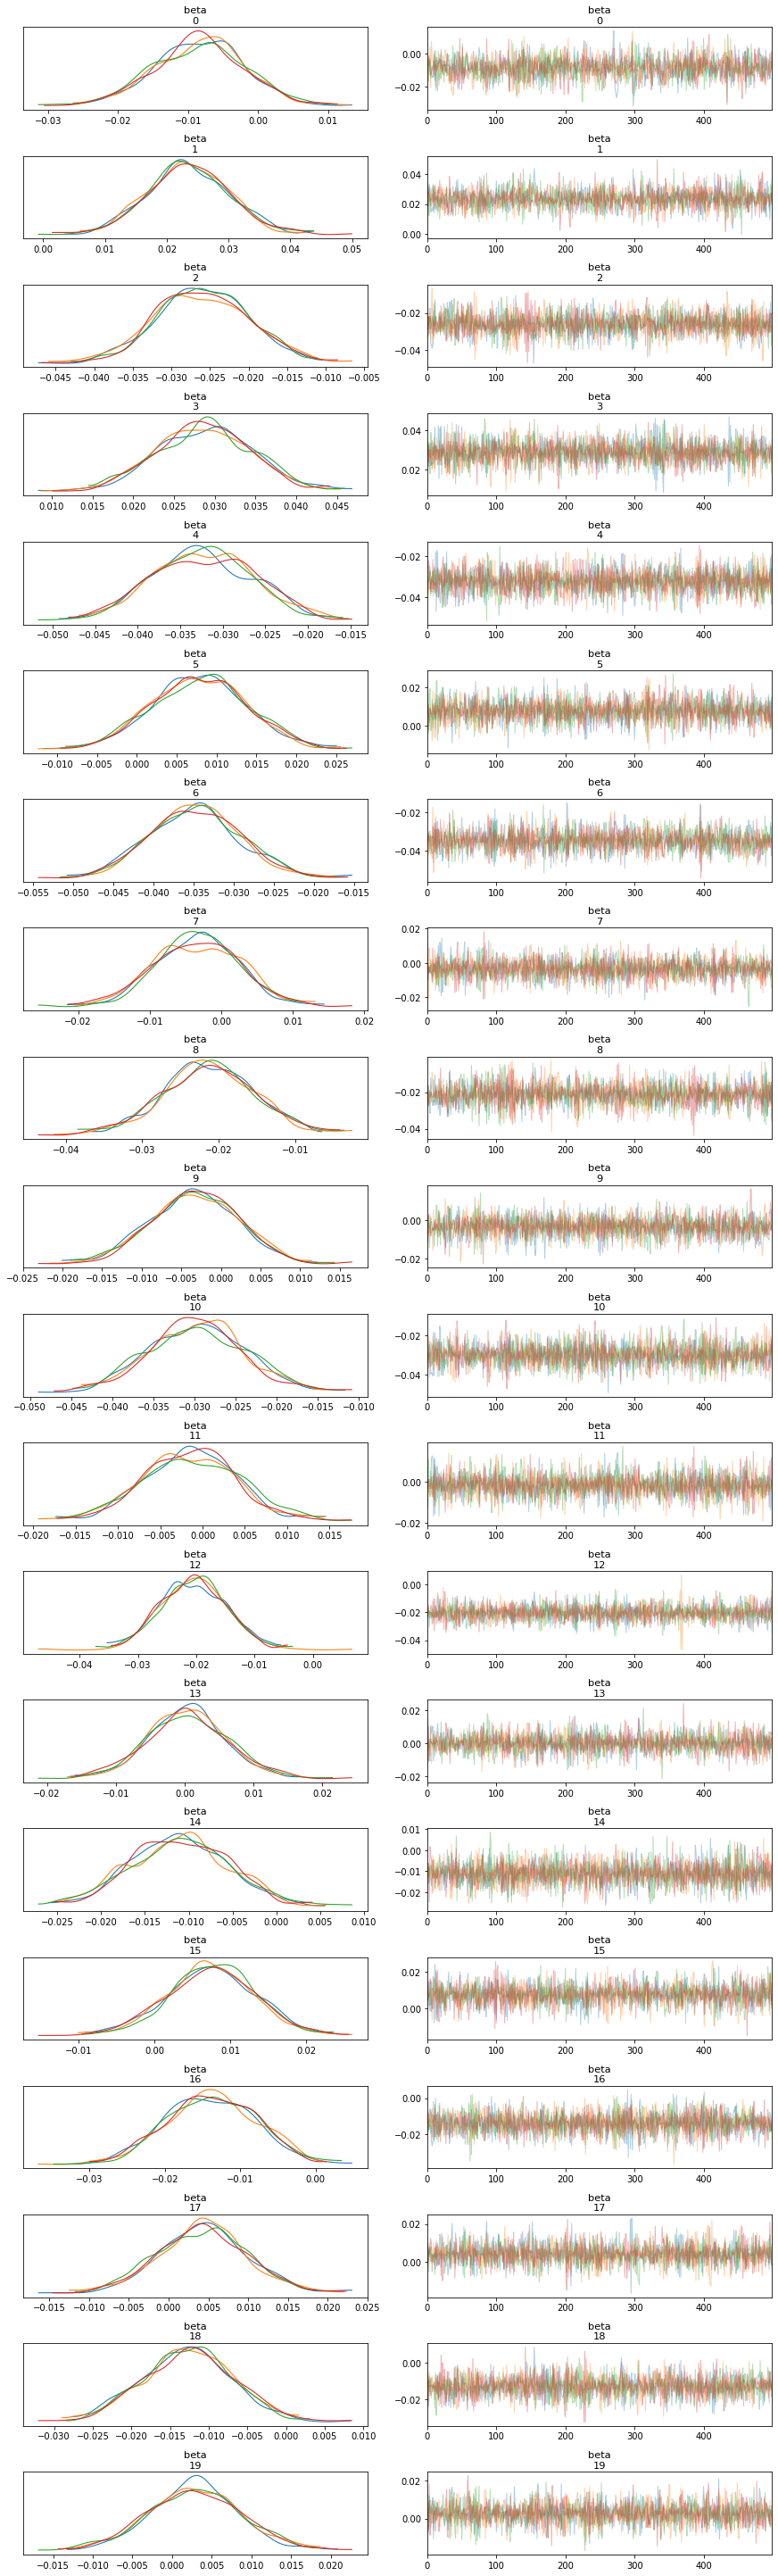

In [268]:
arviz.plot_trace(m1.stan_backend.stan_fit, var_names='beta');

In [284]:
m5.stan_backend.stan_fit.extract()

OrderedDict([('k',
              array([0.01836441, 0.00392237, 0.00652885, ..., 0.01199622, 0.00060866,
                     0.01936171])),
             ('m',
              array([0.08897462, 0.05740354, 0.01672394, ..., 0.04839616, 0.04693905,
                     0.05357959])),
             ('delta',
              array([[-0.04808178],
                     [ 0.06818657],
                     [ 0.03998353],
                     ...,
                     [-0.00071484],
                     [ 0.04649917],
                     [-0.03772535]])),
             ('sigma_obs',
              array([0.02740838, 0.02740333, 0.02562713, ..., 0.02440951, 0.02508754,
                     0.02406626])),
             ('beta',
              array([[0.83004126],
                     [0.89401384],
                     [0.95702226],
                     ...,
                     [0.89668064],
                     [0.91204867],
                     [0.88981033]])),
             ('trend',
              arr

In [314]:
kmean = m5.params['k'].mean()
mmean = m5.params['m'].mean()
deltamean = m5.params['delta'].mean()
sigmamean = m5.params['sigma_obs'].mean()
betamean = m5.params['beta'].mean()

In [357]:
d = 0.1
xvals = np.linspace(betamean - d + 0.1, betamean + d + 0.1, num=40)
yvals = np.linspace(mmean - d, mmean + d, num=40)

In [358]:
values = pd.concat([pd.Series({'x': x, 'y':y, 'value':m5.stan_backend.stan_fit.log_prob(upar=[kmean, y, deltamean, sigmamean, x])}) for x in xvals for y in yvals], axis=1).T

<AxesSubplot:xlabel='y', ylabel='x'>

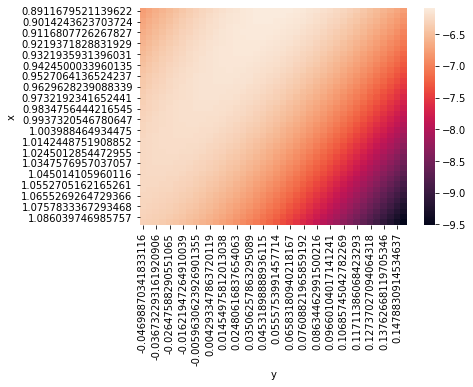

In [359]:
sns.heatmap(values.pivot(index='x', columns='y', values='value'))

In [285]:
m5.stan_backend.stan_fit.log_prob(upar=[0, 0, 0, 0.03, 1])

-6.9292482250305385

In [278]:
m1.stan_backend.stan_fit.grad_log_prob(upar=[1])

ValueError: Number of unconstrained parameters does not match that of the model (1 vs 48).

/Users/leevironty/koodi/kandi/venv/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (434), generating only 20 plots
  UserWarning,


array([[<AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'k'}>],
       [<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'delta\n0'}>,
        <AxesSubplot:title={'center':'delta\n0'}>],
       [<AxesSubplot:title={'center':'sigma_obs'}>,
        <AxesSubplot:title={'center':'sigma_obs'}>],
       [<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n0'}>],
       [<AxesSubplot:title={'center':'trend\n0'}>,
        <AxesSubplot:title={'center':'trend\n0'}>],
       [<AxesSubplot:title={'center':'trend\n1'}>,
        <AxesSubplot:title={'center':'trend\n1'}>],
       [<AxesSubplot:title={'center':'trend\n2'}>,
        <AxesSubplot:title={'center':'trend\n2'}>],
       [<AxesSubplot:title={'center':'trend\n3'}>,
        <AxesSubplot:title={'center':'trend\n3'}>],
       [<AxesSubplot:title={'center':'trend\n4'}>,
        <AxesSubplot:title={'center':'trend\n4'}>]

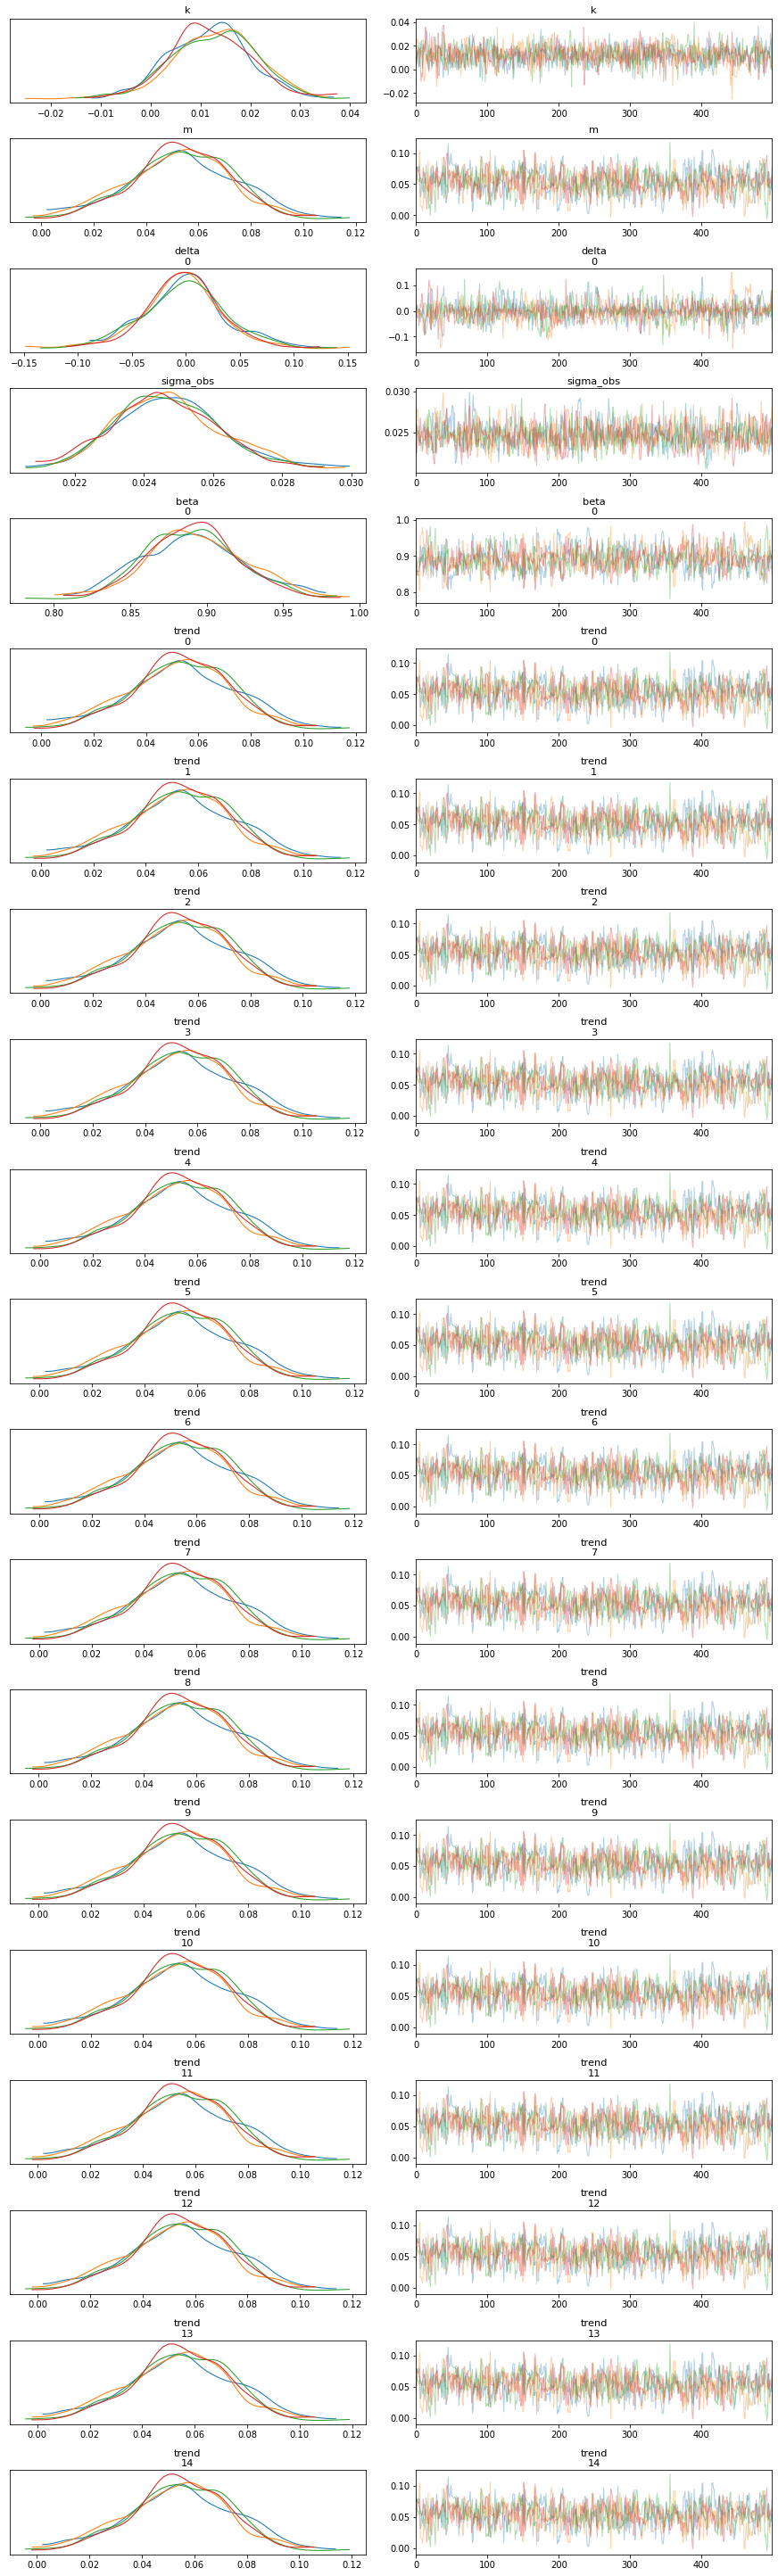

In [350]:
arviz.plot_trace(m5.stan_backend.stan_fit, )

In [50]:
m1.predict(m1.make_future_dataframe(0))

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0   2010-02-05  1.493138e+06  1.351252e+06  1.694709e+06  1.442139e+06   
1   2010-02-12  1.492476e+06  1.360839e+06  1.710638e+06  1.443307e+06   
2   2010-02-19  1.491814e+06  1.323646e+06  1.666527e+06  1.444379e+06   
3   2010-02-26  1.491152e+06  1.279079e+06  1.610748e+06  1.445700e+06   
4   2010-03-05  1.490490e+06  1.280083e+06  1.615696e+06  1.447518e+06   
..         ...           ...           ...           ...           ...   
138 2012-09-28  1.524314e+06  1.237880e+06  1.584014e+06  1.482736e+06   
139 2012-10-05  1.524627e+06  1.280151e+06  1.623405e+06  1.481622e+06   
140 2012-10-12  1.524939e+06  1.291403e+06  1.626796e+06  1.480822e+06   
141 2012-10-19  1.525251e+06  1.259083e+06  1.604366e+06  1.480005e+06   
142 2012-10-26  1.525564e+06  1.255896e+06  1.608263e+06  1.479028e+06   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    1.544351e+06    27720.792931         -34731.235006          91180.710642   
1    1.541370e+06    45445.032813         -14517.149291         104962.419439   
2    1.538393e+06    -1275.153202         -61024.024459          58057.890762   
3    1.535523e+06   -39944.635450         -98536.890222          18536.901688   
4    1.532975e+06   -47975.861314        -104325.864299           9589.581724   
..            ...             ...                   ...                   ...   
138  1.565342e+06  -113417.362395        -167957.248477         -55978.447497   
139  1.566805e+06   -70171.738930        -127979.841275         -13041.226886   
140  1.568346e+06   -63328.192670        -118283.384107          -7329.964030   
141  1.569837e+06   -91293.261361        -149208.832616         -31962.658744   
142  1.571343e+06   -99365.131189        -159775.418979         -37510.188553   

            yearly   yearly_lower   yearly_upper  multiplicative_terms  \
0     27720.792931  -34731.235006   91180.710642                   0.0   
1     45445.032813  -14517.149291  104962.419439                   0.0   
2     -1275.153202  -61024.024459   58057.890762                   0.0   
3    -39944.635450  -98536.890222   18536.901688                   0.0   
4    -47975.861314 -104325.864299    9589.581724                   0.0   
..             ...            ...            ...                   ...   
138 -113417.362395 -167957.248477  -55978.447497                   0.0   
139  -70171.738930 -127979.841275  -13041.226886                   0.0   
140  -63328.192670 -118283.384107   -7329.964030                   0.0   
141  -91293.261361 -149208.832616  -31962.658744                   0.0   
142  -99365.131189 -159775.418979  -37510.188553                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                           0.0                         0.0  1.520859e+06  
1                           0.0                         0.0  1.537921e+06  
2                           0.0                         0.0  1.490539e+06  
3                           0.0                         0.0  1.451207e+06  
4                           0.0                         0.0  1.442514e+06  
..                          ...                         ...           ...  
138                         0.0                         0.0  1.410897e+06  
139                         0.0                         0.0  1.454455e+06  
140                         0.0                         0.0  1.461611e+06  
141                         0.0                         0.0  1.433958e+06  
142                         0.0                         0.0  1.426199e+06  

[143 rows x 16 columns]

In [56]:
m1.history['ds'].dt.to_pydatetime().shape

(143,)

In [112]:
import arviz

In [125]:
arviz.waic(m5.stan_backend.stan_fit)

TypeError: log likelihood not found in inference data object

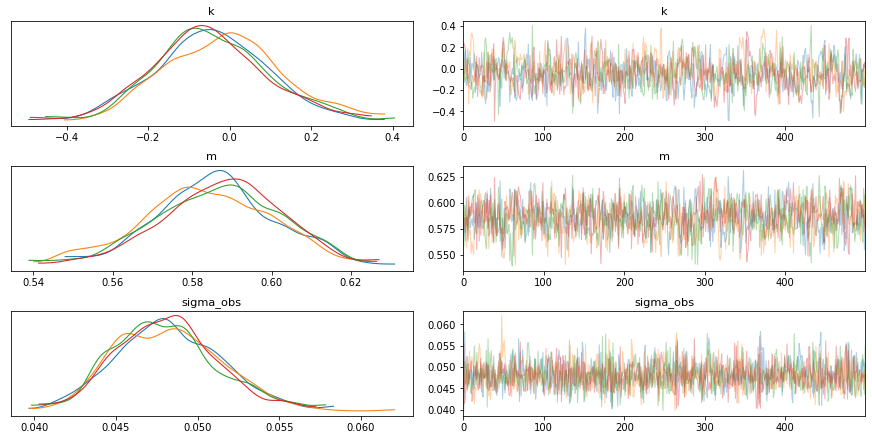

In [116]:
arviz.plot_trace(m1.stan_backend.stan_fit, var_names=['k', 'm', 'sigma_obs']);

In [120]:
arviz.bfmi(m5.stan_backend.stan_fit)

array([1.02127821, 0.99166129, 0.99717696, 0.85392779])

In [ ]:
arviz.loo